In [23]:
!pip install matplotlib
!pip install networkx
!pip install tsplib95
!pip install vrplib

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tsplib95
import itertools as it
import random
import vrplib
import math
import pandas as pd
import time
from copy import deepcopy
from operator import attrgetter
import threading

In [25]:
def draw_graph(G):
    pos = {i: (data['x'], data['y']) for i, data in G.nodes(data=True)}
    plt.figure(figsize=(8, 6))    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos)
    labels = {i: f'{i} (d={data["demand"]})' for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    plt.title("Gráfico de nodos VRP (Vehicle Routing Problem)")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()

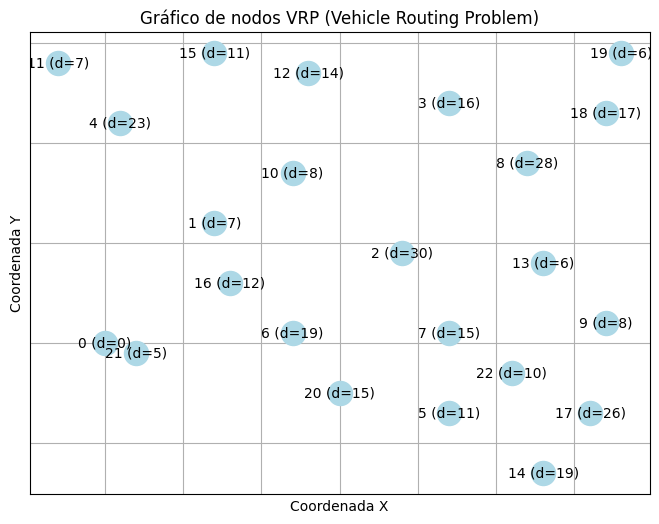

In [60]:
G = nx.MultiDiGraph()

instance = vrplib.read_instance("./Vrp-Set-P/P/P-n23-k8.vrp")
demand = instance['demand']
nodes_coords = instance['node_coord']
for i, (x, y) in enumerate(nodes_coords):
    G.add_node(i, x=int(x), y=int(y), demand=int(demand[i]))

G.edges(data=True)
draw_graph(G)

In [27]:
def distancia_euclidiana(node1, node2, G):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calcular_custo(rota, G):
    custo = 0
    for i in range(len(rota) - 1):
        custo += distancia_euclidiana(rota[i], rota[i+1], G)
    return custo

def calcular_custo_total(rotas, G):
    return sum(calcular_custo(rota, G) for rota in rotas)

In [28]:
def inicializar_solucao(G, capacidade):
    deposito = 0
    nos = list(G.nodes)
    nos.remove(deposito)
    random.shuffle(nos)
    
    rotas = []
    rota_atual = [deposito]
    capacidade_atual = 0

    for no in nos:
        demanda = G.nodes[no]['demand']
        if capacidade_atual + demanda > capacidade:
            rota_atual.append(deposito)
            rotas.append(rota_atual)
            rota_atual = [deposito]
            capacidade_atual = 0
        rota_atual.append(no)
        capacidade_atual += demanda

    rota_atual.append(deposito)
    rotas.append(rota_atual)

    return rotas

In [41]:
def selecao(populacao, G, elitismo):
    populacao.sort(key=lambda x: calcular_custo_total(x, G))
    return populacao[:elitismo] + random.sample(populacao[elitismo:], len(populacao) // 2 - elitismo)

def crossover(pai1, pai2, G, capacidade):
    if len(pai1) < 3 or len(pai2) < 3:
        return pai1[:] 
    ponto_corte = random.randint(1, len(pai1) - 2)
    filho = pai1[:ponto_corte]
    clientes_filho = set([cliente for rota in filho for cliente in rota if cliente != 0])
    
    for rota in pai2:
        nova_rota = [0]
        capacidade_atual = 0
        for cliente in rota[1:-1]:
            if cliente not in clientes_filho:
                demanda = G.nodes[cliente]['demand']
                if capacidade_atual + demanda <= capacidade:
                    nova_rota.append(cliente)
                    clientes_filho.add(cliente)
                    capacidade_atual += demanda
        nova_rota.append(0)
        if len(nova_rota) > 3:
            filho.append(nova_rota)
        elif len(nova_rota) == 3:
            cliente_unico = nova_rota[1]
            realocado = False
            for rota in filho:
                capacidade_atual = sum(G.nodes[c]['demand'] for c in rota if c != 0)
                if capacidade_atual + G.nodes[cliente_unico]['demand'] <= capacidade:
                    rota.insert(-1, cliente_unico)
                    clientes_filho.add(cliente_unico)
                    realocado = True
                    break
            if not realocado:
                filho.append(nova_rota)
                clientes_filho.add(cliente_unico)
    
    # Adicionar clientes faltantes
    todos_clientes = set(G.nodes) - {0}
    faltantes = todos_clientes - clientes_filho
    for cliente in faltantes:
        demanda = G.nodes[cliente]['demand']
        alocado = False
        for rota in filho:
            capacidade_atual = sum(G.nodes[c]['demand'] for c in rota if c != 0)
            if capacidade_atual + demanda <= capacidade:
                rota.insert(-1, cliente)
                alocado = True
                break
        if not alocado:
            filho.append([0, cliente, 0])

    return filho

def mutacao(filho, G, capacidade, taxa_mutacao):
    if random.random() < taxa_mutacao:
        if random.random() < 0.5:  # Swap move entre duas rotas
            nova_solucao = [rota[:] for rota in filho]
            rota1, rota2 = random.sample(nova_solucao, 2)
            
            if len(rota1) > 2 and len(rota2) > 2:
                idx1 = random.randint(1, len(rota1) - 2)
                idx2 = random.randint(1, len(rota2) - 2)
                demanda1 = G.nodes[rota1[idx1]]['demand']
                demanda2 = G.nodes[rota2[idx2]]['demand']
                capacidade_rota1 = sum(G.nodes[no]['demand'] for no in rota1 if no != 0)
                capacidade_rota2 = sum(G.nodes[no]['demand'] for no in rota2 if no != 0)
                
                if (capacidade_rota1 - demanda1 + demanda2 <= capacidade and
                    capacidade_rota2 - demanda2 + demanda1 <= capacidade):
                    rota1[idx1], rota2[idx2] = rota2[idx2], rota1[idx1]
                    filho = nova_solucao
        else:  # Shift move dentro da mesma rota
            nova_solucao = [rota[:] for rota in filho]
            rota = random.choice(nova_solucao)
            if len(rota) > 3:
                idx1, idx2 = random.sample(range(1, len(rota) - 1), 2)
                rota[idx1], rota[idx2] = rota[idx2], rota[idx1]
                filho = nova_solucao
                
    return filho

def gerar_populacao_inicial(G, capacidade, tamanho_populacao):
    return [inicializar_solucao(G, capacidade) for _ in range(tamanho_populacao)]

def migracao(ilhas, tamanho_migracao):
    for i in range(len(ilhas)):
        destino = (i + 1) % len(ilhas)
        migrantes = ilhas[i][:tamanho_migracao]
        ilhas[destino].extend(migrantes)
        ilhas[i] = ilhas[i][tamanho_migracao:]


In [30]:
def gerar_populacao_inicial(G, capacidade, tamanho_populacao):
    return [inicializar_solucao(G, capacidade) for _ in range(tamanho_populacao)]

In [31]:
def island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, tamanho_migracao, intervalo_migracao, elitismo):
    ilhas = [gerar_populacao_inicial(G, capacidade, tamanho_populacao) for _ in range(num_ilhas)]
    melhor_solucao = None
    melhor_custo = float('inf')
    
    lock = threading.Lock()

    def evoluir_ilha_com_migracao(ilha, id_ilha):
        nonlocal ilhas
        for geracao in range(num_geracoes):
            with lock: 
                ilha[:] = selecao(ilha, G, elitismo)
            
            nova_geracao = deepcopy(ilha)
            while len(nova_geracao) < tamanho_populacao:
                pais = random.sample(ilha, 2)
                filho = crossover(pais[0], pais[1], G, capacidade)
                filho = mutacao(filho, G, capacidade, taxa_mutacao)
                nova_geracao.append(filho)
            
            with lock:
                ilha[:] = nova_geracao

            if geracao % intervalo_migracao == 0 and geracao > 0:
                with lock:
                    migracao(ilhas, tamanho_migracao)

    threads = []
    for i in range(num_ilhas):
        thread = threading.Thread(target=evoluir_ilha_com_migracao, args=(ilhas[i], i))
        threads.append(thread)
        thread.start()
    
    for thread in threads:
        thread.join()

    for ilha in ilhas:
        for solucao in ilha:
            custo = calcular_custo_total(solucao, G)
            if custo < melhor_custo:
                melhor_solucao = solucao
                melhor_custo = custo
    
    return melhor_solucao, melhor_custo

In [45]:
capacidade = instance['capacity']
tamanho_populacao = 100
num_ilhas = 4
elitismo = 50
num_geracoes = 50
taxa_mutacao = 0.5
taxa_migracao = 0.1
tamanho_migracao = max(1, int(tamanho_populacao * taxa_migracao))
intervalo_migracao = 300

In [46]:
melhor_solucao, melhor_custo = island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, tamanho_migracao, intervalo_migracao, elitismo)
print("Melhor solução:", melhor_solucao)
print("Custo da melhor solução:", melhor_custo)

i = 1
for rota in melhor_solucao:
    capacidade_rota = 0
    for nodo in rota:
        capacidade_rota += G.nodes[nodo]['demand']
    print(f'Capacidade {i}: {capacidade_rota}')
    i += 1

Melhor solução: [[0, 8, 13, 0], [0, 7, 14, 0], [0, 2, 0], [0, 11, 4, 0], [0, 15, 12, 10, 0], [0, 3, 9, 5, 0], [0, 1, 0], [0, 6, 0]]
Custo da melhor solução: 451.335080208618
Capacidade 1: 34
Capacidade 2: 34
Capacidade 3: 30
Capacidade 4: 30
Capacidade 5: 33
Capacidade 6: 35
Capacidade 7: 19
Capacidade 8: 31


In [13]:
def testar_parametros(combinacoes_parametros, G, capacidade, num_testes):
    resultados = []
    
    for num_ilhas, num_geracoes, tamanho_populacao, elitismo, taxa_mutacao, tamanho_migracao, intervalo_migracao in combinacoes_parametros:
        custos = []
        tempos = []
        melhores_solucoes = []

        for _ in range(num_testes):
            inicio = time.time()
            melhor_solucao, melhor_custo = island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, tamanho_migracao, intervalo_migracao, elitismo)
            fim = time.time()

            custos.append(melhor_custo)
            tempos.append((fim - inicio) * 1000)  # Convertendo para milissegundos
            melhores_solucoes.append(melhor_solucao)

        media_custos = sum(custos) / num_testes
        melhor_custo_global = min(custos)
        media_tempo = sum(tempos) / num_testes
        
        melhor_solucao_global = melhores_solucoes[custos.index(melhor_custo_global)]
        
        resultados.append({
            'Número de ilhas': num_ilhas,
            'Máximo de gerações': num_geracoes,
            'Tamanho populacao': tamanho_populacao,
            'Elitismo': elitismo,
            'Taxa mutacao': taxa_mutacao,
            'Tamanho migracao': tamanho_migracao,
            'Intervalo migracao': intervalo_migracao,
            'Média dos custos': media_custos,
            'Melhor custo': melhor_custo_global,
            'Média do tempo (ms)': media_tempo,
            'Melhor solução': melhor_solucao_global,
        })
        
        print(f"Parâmetros: Elitismo={elitismo}, Taxa mutação={taxa_mutacao}, Tamanho Migração={tamanho_migracao}, Intervalo Migração={intervalo_migracao}")
        print(f"-> Média Custo: {media_custos:.2f}, Melhor Custo: {melhor_custo_global:.2f}, Média Tempo: {media_tempo:.2f} ms")
    
    return resultados

In [14]:
# num_ilhas = [2, 4, 6, 8]
# num_geracoes = [200, 400, 600, 800, 1000]
# tamanho_populacao = [100, 150, 200]

# num_ilhas = [8]
# num_geracoes = [200]
# tamanho_populacao = [150]
# elitismo = [30, 40, 50]
# taxa_mutacao = [0.2, 0.4, 0.6, 0.8]
# tamanho_migracao = [4, 8, 10]
# intervalo_migracao = [20, 60, 80, 100]

num_ilhas = [8]
num_geracoes = [200]
tamanho_populacao = [150]
elitismo = [50]
taxa_mutacao = [0.6]
tamanho_migracao = [10]
intervalo_migracao = [100]

combinacoes_parametros = list(it.product(num_ilhas, num_geracoes, tamanho_populacao, elitismo, taxa_mutacao, tamanho_migracao, intervalo_migracao))

In [61]:
capacidade = instance['capacity']

topologia = 'anel'

In [62]:
resultados = testar_parametros(combinacoes_parametros, G, capacidade, 15)

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='Média dos custos').head(10))

Parâmetros: Elitismo=50, Taxa mutação=0.6, Tamanho Migração=10, Intervalo Migração=100
-> Média Custo: 535.31, Melhor Custo: 531.17, Média Tempo: 11822.31 ms
   Número de ilhas  Máximo de gerações  Tamanho populacao  Elitismo  \
0                8                 200                150        50   

   Taxa mutacao  Tamanho migracao  Intervalo migracao  Média dos custos  \
0           0.6                10                 100        535.305479   

   Melhor custo  Média do tempo (ms)  \
0    531.173804         11822.305616   

                                      Melhor solução  
0  [[0, 17, 9, 13, 0], [0, 5, 14, 22, 0], [0, 6, ...  


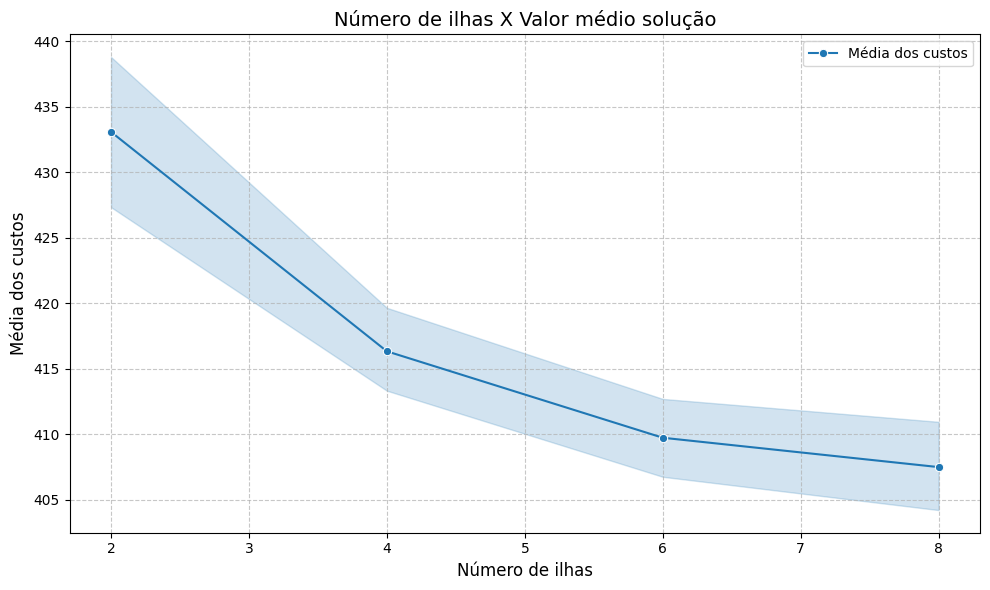

In [32]:
plt.figure(figsize=(10, 6))

grouped = df_resultados.groupby('Número de ilhas')['Média dos custos'].mean()

sns.lineplot(
    data=df_resultados,
    x='Número de ilhas',
    y='Média dos custos',
    marker='o',
    label='Média dos custos'
)

plt.title('Número de ilhas X Valor médio solução', fontsize=14)
plt.xlabel('Número de ilhas', fontsize=12)
plt.ylabel('Média dos custos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

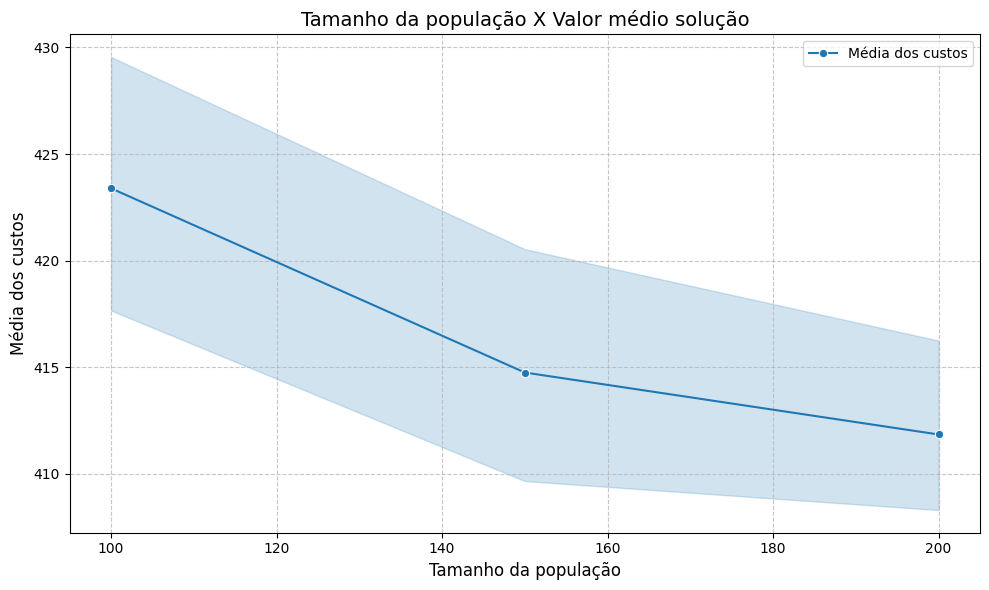

In [33]:
plt.figure(figsize=(10, 6))

grouped = df_resultados.groupby('Tamanho populacao')['Média dos custos'].mean()

sns.lineplot(
    data=df_resultados,
    x='Tamanho populacao',
    y='Média dos custos',
    marker='o',
    label='Média dos custos'
)

plt.title('Tamanho da população X Valor médio solução', fontsize=14)
plt.xlabel('Tamanho da população', fontsize=12)
plt.ylabel('Média dos custos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

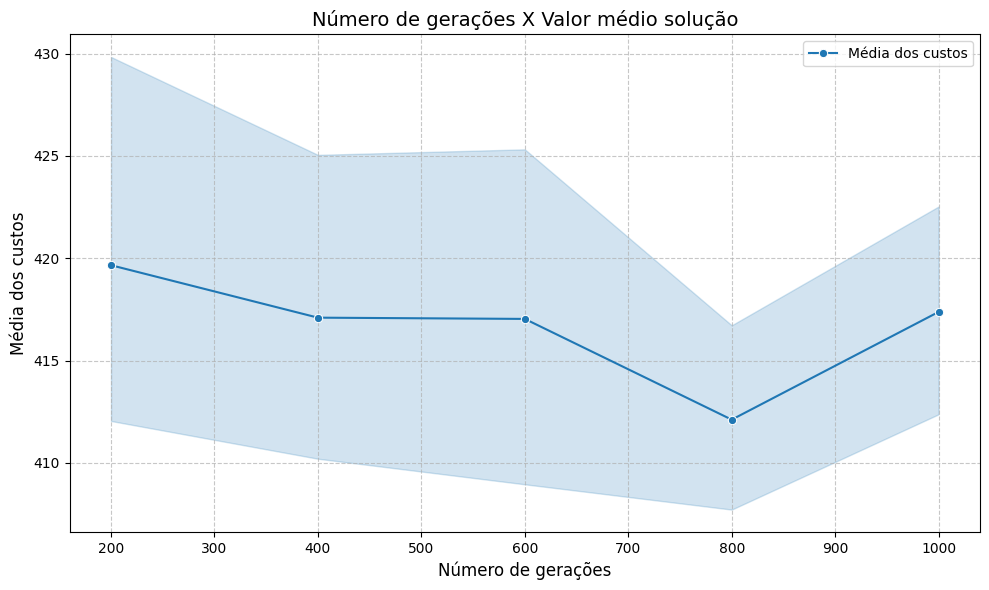

In [34]:
plt.figure(figsize=(10, 6))

grouped = df_resultados.groupby('Máximo de gerações')['Média dos custos'].mean()

sns.lineplot(
    data=df_resultados,
    x='Máximo de gerações',
    y='Média dos custos',
    marker='o',
    label='Média dos custos'
)

plt.title('Número de gerações X Valor médio solução', fontsize=14)
plt.xlabel('Número de gerações', fontsize=12)
plt.ylabel('Média dos custos', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()